# Mask Classification

This Notebook contains a model trainable from scratch a model based on VGG16

In [12]:
import os
import numpy as np 
import tensorflow as tf 
import pandas
import random

SEED = 1234

tf.random.set_seed(SEED)

cwd = os.getcwd();

In [13]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


apply_data_augmentation = True

if apply_data_augmentation: #if data augmentation is enabled, create the generator
     train_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        shear_range = 0.2, #added for TL
                                        validation_split = 0.3,
                                        rescale=1./255)
else: #rescale only the image
     train_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)                                       

#rescale only on validation dataset and test dataset
valid_data_gen = ImageDataGenerator(rescale = 1./255)

test_data_gen = ImageDataGenerator(rescale = 1./255)


In [26]:
#width and height of imgaes
img_w = 256
img_h = 256

num_classes = 3

classes = ["NO PERSON", "ALL THE PEOPLE", "SOMEONE"]

bs = 16 #batch size
#bs = 32 #batch for basic model

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Loading data 
import json 

#setting dirs
dataset_dir = os.path.join(cwd, "MaskDataset")
training_dir = os.path.join(dataset_dir, "training")
validation_dir = training_dir


#reading json file
with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)


dataframe = pandas.DataFrame(dic.items())

dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)

dataframe["class"] = dataframe["class"].astype(str)

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               subset='training',
                                               shuffle=True,
                                               seed=SEED)

valid_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               #directory='full_dataset',
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               subset='validation',
                                               shuffle=True,
                                               seed=SEED) 


Found 3930 validated image filenames belonging to 3 classes.
Found 1684 validated image filenames belonging to 3 classes.


In [47]:
#Creating Dataset objects

train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

valid_dataset = valid_dataset.repeat()  

  




In [18]:
# Architecture: Features extraction -> Classifier

model = tf.keras.Sequential()

transfer_learning = True

if transfer_learning:
    # Load VGG16 Model

    vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
    # Create Model
    # ------------

    finetuning = True

    if finetuning:
        freeze_until = 14 # layer from which we want to fine-tune

        for layer in vgg.layers:
             layer.trainable = False

        for layer in vgg.layers[:freeze_until]:
             layer.trainable = True

    else:
         for layer in vgg.layers[:]:
            layer.trainable = False
        
    model.add(vgg)

else:
    #Creating a CNN from scratch
    start_f = 8
    depth = 5
    # Features extraction
    for i in range(depth):
        if i == 0:
            input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]

        # Conv block: Conv2D -> Activation -> Pooling
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                        kernel_size=(3, 3),
                                        strides=(1, 1),
                                        padding='same',
                                        input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2
    
# Classifier
model.add(tf.keras.layers.Flatten())
#Basic Model
#model.add(tf.keras.layers.Dense(units=512, activation='relu'))
#TL
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [19]:
# Load the model
load_model = False
if load_model:
    latest = tf.train.latest_checkpoint(os.path.join("C:\\Users\\Giovanni\\Desktop\\Università\\Magistrale\\ANN\\AN2DL-homeworks\\image-classification\\classification_experiments\\CNN_Nov19_21-28-21\\ckpts", ""))
    model.load_weights(latest, by_name=False)

In [20]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-5 #basic lr 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#if load_model == True:
#    model.evaluate(valid_dataset.take(len(valid_gen)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 24,219,203
Trainable params: 10,060,355
Non-trainable params: 14,158,848
_________________________________________________________________


In [21]:
from datetime import datetime



exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    callbacks.append(es_callback)

In [22]:
model.fit(x=train_dataset,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

Epoch 1/30
351/351 [==============================] - 712s 2s/step - loss: 1.0383 - accuracy: 0.4501 - val_loss: 0.8142 - val_accuracy: 0.6128
Epoch 2/30
351/351 [==============================] - 700s 2s/step - loss: 0.6990 - accuracy: 0.6776 - val_loss: 0.5552 - val_accuracy: 0.7508
Epoch 3/30
351/351 [==============================] - 731s 2s/step - loss: 0.5647 - accuracy: 0.7369 - val_loss: 0.4837 - val_accuracy: 0.7797
Epoch 4/30
351/351 [==============================] - 722s 2s/step - loss: 0.5001 - accuracy: 0.7709 - val_loss: 0.4655 - val_accuracy: 0.7834
Epoch 5/30
351/351 [==============================] - 698s 2s/step - loss: 0.4705 - accuracy: 0.7827 - val_loss: 0.4361 - val_accuracy: 0.8080
Epoch 6/30
351/351 [==============================] - 700s 2s/step - loss: 0.4325 - accuracy: 0.8073 - val_loss: 0.4174 - val_accuracy: 0.8094
Epoch 7/30
351/351 [==============================] - 699s 2s/step - loss: 0.4163 - accuracy: 0.8199 - val_loss: 0.3985 - val_accuracy: 0.8185

KeyboardInterrupt: 

In [12]:
#check that is all ok

#iterator = iter(valid_dataset)



#from PIL import Image

#for i in range(10):
#    sample, target = next(iterator)
#    sample_ = sample[0, ...]

#    img = Image.fromarray(np.uint8(np.array(sample_)*255.))
#    img = img.resize([img_w,img_h])
#    img_array = np.array(img)
#    img_array = np.expand_dims(img_array, 0) 
#    img_array = tf.cast(img_array, tf.float32) / 255.
#    prediction = model.predict(img_array)
#    img
#    print("Predicted:"+classes[np.argmax(prediction)])
#    print("Original:" +classes[tf.argmax(target[0], axis=0)])

#sample_
#class_names[tf.argmax(target[0], axis=0)]

In [13]:
# Test Dataset 
# Useful if you want to see images with predictions  

#from PIL import Image
#image_filenames = next(os.walk('MaskDataset/test'))[2]

#results = {}
#for image_name in image_filenames:
#   img = Image.open('MaskDataset/test/'+image_name).convert('RGB')
#   img = img.resize((img_w,img_h))
#   img_array = np.array(img)
#   img_array = np.expand_dims(img_array, 0) 
#   img_array = tf.cast(img_array, tf.float32) / 255.
#   prediction = model.predict(img_array)
#   img
#   classes[np.argmax(prediction)]
   


In [19]:
#Creating CSV

import os
from datetime import datetime
from PIL import Image

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


image_filenames = next(os.walk('MaskDataset/test'))[2]

results = {}
for image_name in image_filenames:
   img = Image.open('MaskDataset/test/'+image_name).convert('RGB')
   img = img.resize((img_w,img_h))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
   img_array = tf.cast(img_array, tf.float32) / 255.
   prediction = model.predict(img_array)
   results[image_name] = np.argmax(prediction)

create_csv(results)            

In [16]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

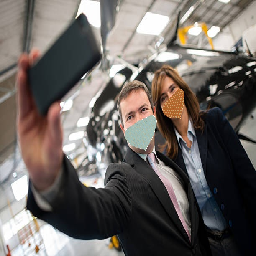

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 3)

In [17]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras

decode_predictions = keras.applications.xception.decode_predictions

iterator = iter(valid_dataset)



from PIL import Image

for i in range(1):
    sample, target = next(iterator)
    sample_ = sample[0, ...]

    img = Image.fromarray(np.uint8(np.array(sample_)*255.))
    img = img.resize([img_w,img_h])
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0) 
    img_array = tf.cast(img_array, tf.float32) / 255.
    prediction = model.predict(img_array)
    img
    preds = model.predict(img_array)
    print("Predicted:", decode_predictions(preds, top=1)[0])
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    print("Predicted:"+classes[np.argmax(prediction)])
    print("Original:" +classes[tf.argmax(target[0], axis=0)])

        # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "elephant_cam.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

sample_
class_names[tf.argmax(target[0], axis=0)]